# Few shot pour la classification de signaux

## Definition : Few shot Learning

You have a classifier performing well on three classes 0,1,2, 3, 4, 5 but suddenly there are classes 6, 7, 8, 9, 10, 11 which appear but we do not have a lot of data about these classes (only 5 each) and we need to recognize these classes. This is Few-Shot Learning.
Training a standard neural network on so little data would cause it to overfit and fail completely.

## Imports et chargement des données

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

TRAIN_PATH = "data/train.hdf5"
ENROLL_PATH = "data/endroll.hdf5"
TEST_PATH= "data/test_fewshot.hdf5"


paths = {
    "train": TRAIN_PATH,
    "enroll":ENROLL_PATH,
    "test":TEST_PATH
}

for name, path in paths.items():
    print(f"\n=== {name.upper()} ===")
    with h5py.File(path, "r") as f:
        print("Clés :", list(f.keys()))


def load_file(path):
    data = h5py.File(path , 'r')
    signals = np.array(data['signaux'])
    snr =  np.array(data['snr'])
    labels_id = np.array(data['labels'])
    return signals, snr, labels_id






=== TRAIN ===
Clés : ['label_name', 'labels', 'signaux', 'snr']

=== ENROLL ===
Clés : ['labels', 'signaux', 'snr']

=== TEST ===
Clés : ['labels', 'signaux', 'snr']


## Data exploration

### Simple exploration

In [3]:
def explore_data(path, plot=True):

    signals, snr, labels_id = load_file(path)

    print("-------General Info-------")
    print("Type signal type : " , type(signals))
    print("Type signal snr : " , type(snr))
    print("Type gnal labels : " , type(labels_id))

    print("-------Shape Info-------")
    print("Shape signal type : " , signals.shape)
    print("Shape signal snr : " , snr.shape)
    print("Shape signal labels : " , labels_id.shape)

    print("-------Dtype Info-------")
    print("Dtype signal type : " , signals.dtype)
    print("Dtype signal snr : " , snr.dtype)
    print("Dtype signal labels : " , labels_id.dtype)

    print("-------Unique Values Info-------")
    print("Unique signal snr : " , np.unique(snr))
    print("Unique signal labels : " , np.unique(labels_id))


    example_idx = 0
    example_signal = signals[example_idx]
    example_snr = snr[example_idx]
    example_label = labels_id[example_idx]

    if plot:
        plt.figure(figsize=(12,4))
        plt.plot(example_signal)
        plt.title(f"Example Signal - Label: {example_label}, SNR: {example_snr}dB")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()

#### Train

-------General Info-------
Type signal type :  <class 'numpy.ndarray'>
Type signal snr :  <class 'numpy.ndarray'>
Type gnal labels :  <class 'numpy.ndarray'>
-------Shape Info-------
Shape signal type :  (30000, 2048, 2)
Shape signal snr :  (30000,)
Shape signal labels :  (30000,)
-------Dtype Info-------
Dtype signal type :  float32
Dtype signal snr :  int16
Dtype signal labels :  int8
-------Unique Values Info-------
Unique signal snr :  [ 0 10 20 30]
Unique signal labels :  [0 1 2 3 4 5]


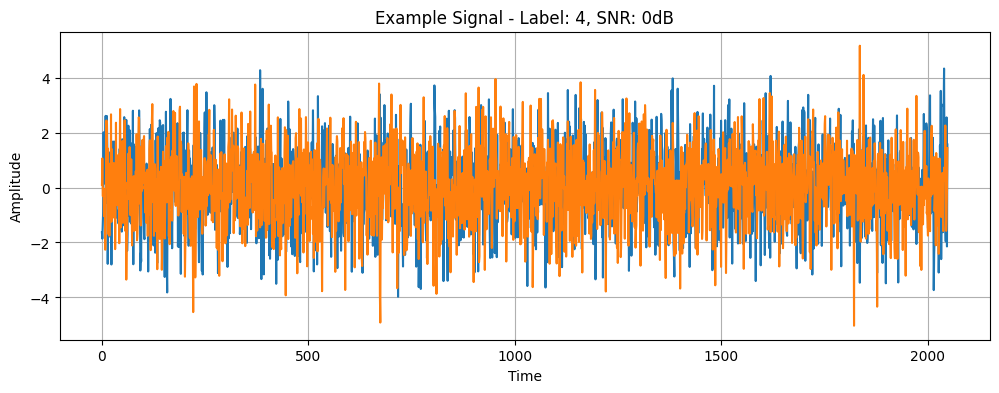

In [4]:
explore_data(TRAIN_PATH)

#### Enroll

-------General Info-------
Type signal type :  <class 'numpy.ndarray'>
Type signal snr :  <class 'numpy.ndarray'>
Type gnal labels :  <class 'numpy.ndarray'>
-------Shape Info-------
Shape signal type :  (500, 2048, 2)
Shape signal snr :  (500,)
Shape signal labels :  (500,)
-------Dtype Info-------
Dtype signal type :  float32
Dtype signal snr :  int16
Dtype signal labels :  int8
-------Unique Values Info-------
Unique signal snr :  [10 20 30]
Unique signal labels :  [ 6  7  8  9 10 11]


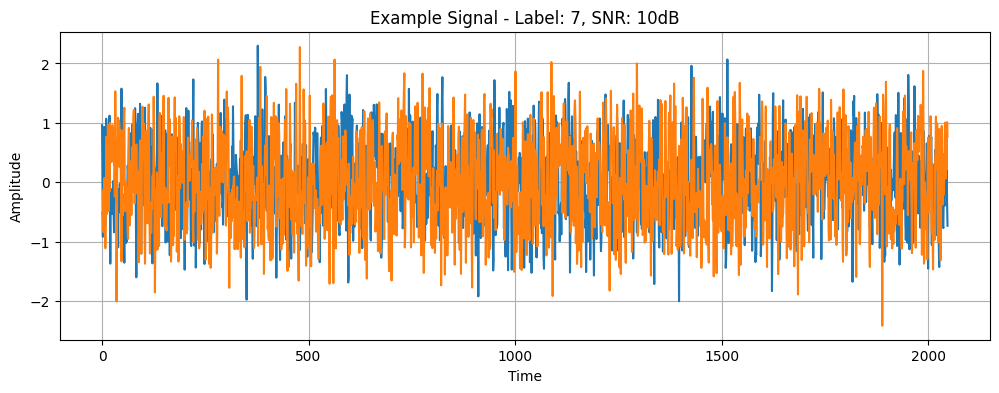

In [5]:
explore_data(ENROLL_PATH)

#### Test

-------General Info-------
Type signal type :  <class 'numpy.ndarray'>
Type signal snr :  <class 'numpy.ndarray'>
Type gnal labels :  <class 'numpy.ndarray'>
-------Shape Info-------
Shape signal type :  (500, 2048, 2)
Shape signal snr :  (500,)
Shape signal labels :  (500,)
-------Dtype Info-------
Dtype signal type :  float32
Dtype signal snr :  int16
Dtype signal labels :  int8
-------Unique Values Info-------
Unique signal snr :  [10]
Unique signal labels :  [ 6  7  8  9 10 11]


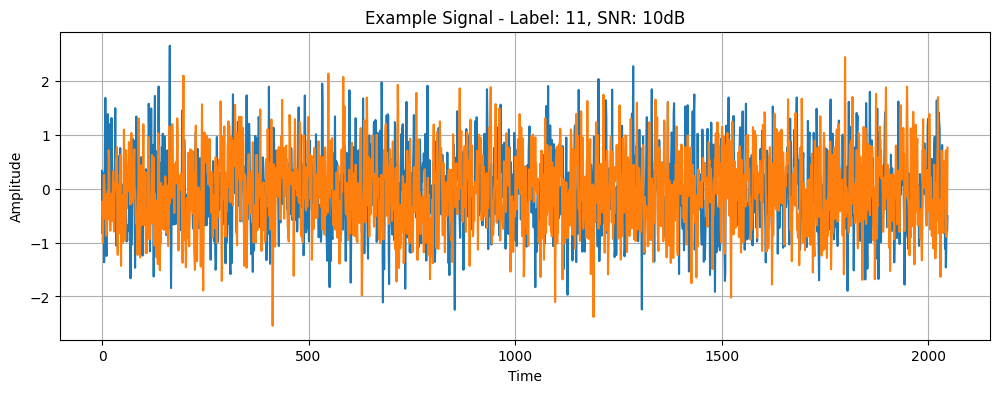

In [6]:
explore_data(TEST_PATH)

### Distributions

#### Train

/tmp/ipython-input-479499046.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
/tmp/ipython-input-479499046.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")


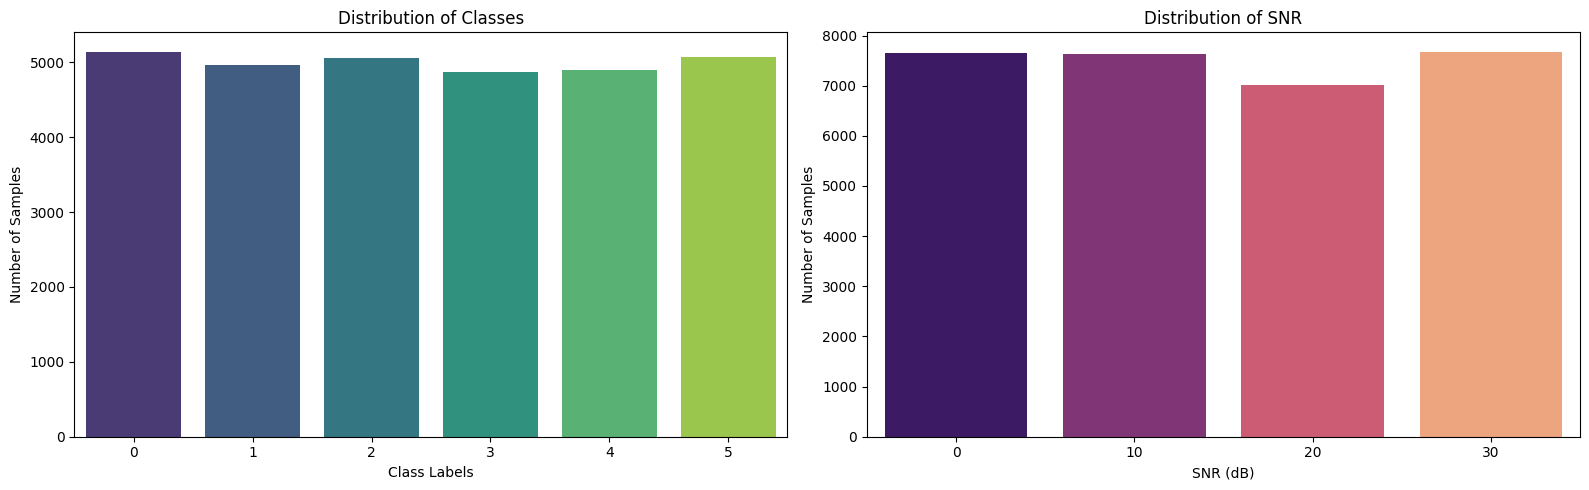

In [7]:
signals, snr, labels_id = load_file(TRAIN_PATH)
unique_labels, count_labels = np.unique(labels_id, return_counts=True)
unique_snr, count_snr = np.unique(snr, return_counts=True)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
axes[0].set_title("Distribution of Classes")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Samples")

sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")
axes[1].set_title("Distribution of SNR")
axes[1].set_xlabel("SNR (dB)")
axes[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()

#### Enroll

/tmp/ipython-input-3825890742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
/tmp/ipython-input-3825890742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")


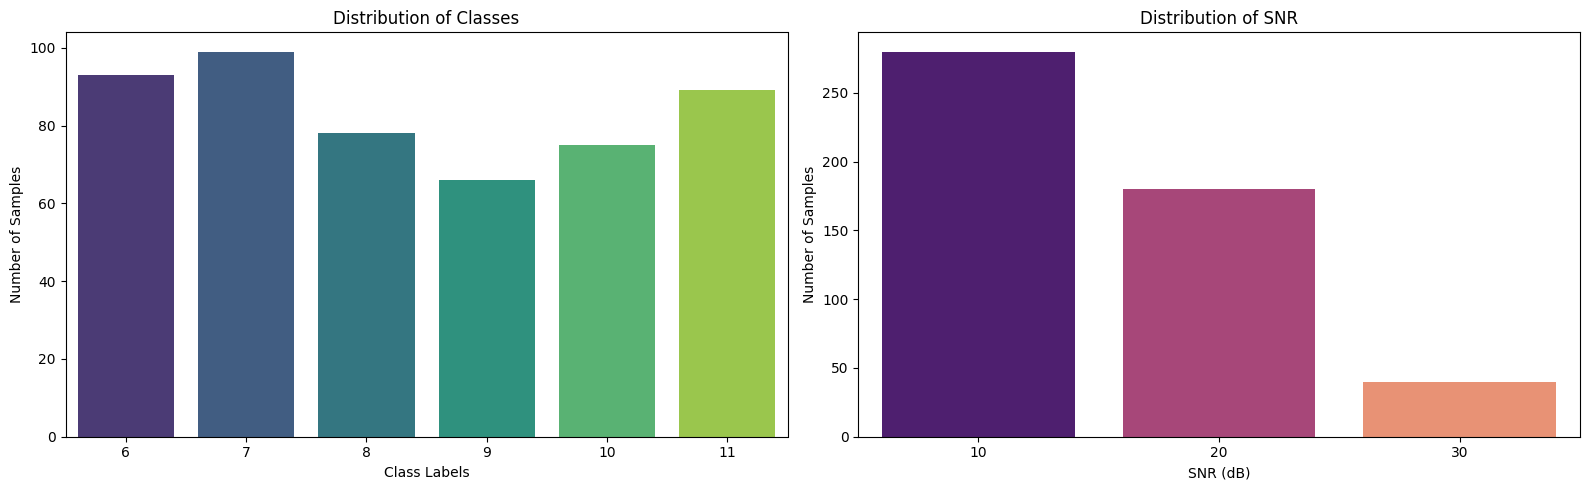

In [8]:
signals, snr, labels_id = load_file(ENROLL_PATH)
unique_labels, count_labels = np.unique(labels_id, return_counts=True)
unique_snr, count_snr = np.unique(snr, return_counts=True)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
axes[0].set_title("Distribution of Classes")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Samples")

sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")
axes[1].set_title("Distribution of SNR")
axes[1].set_xlabel("SNR (dB)")
axes[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()

#### Test

/tmp/ipython-input-469705572.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
/tmp/ipython-input-469705572.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")


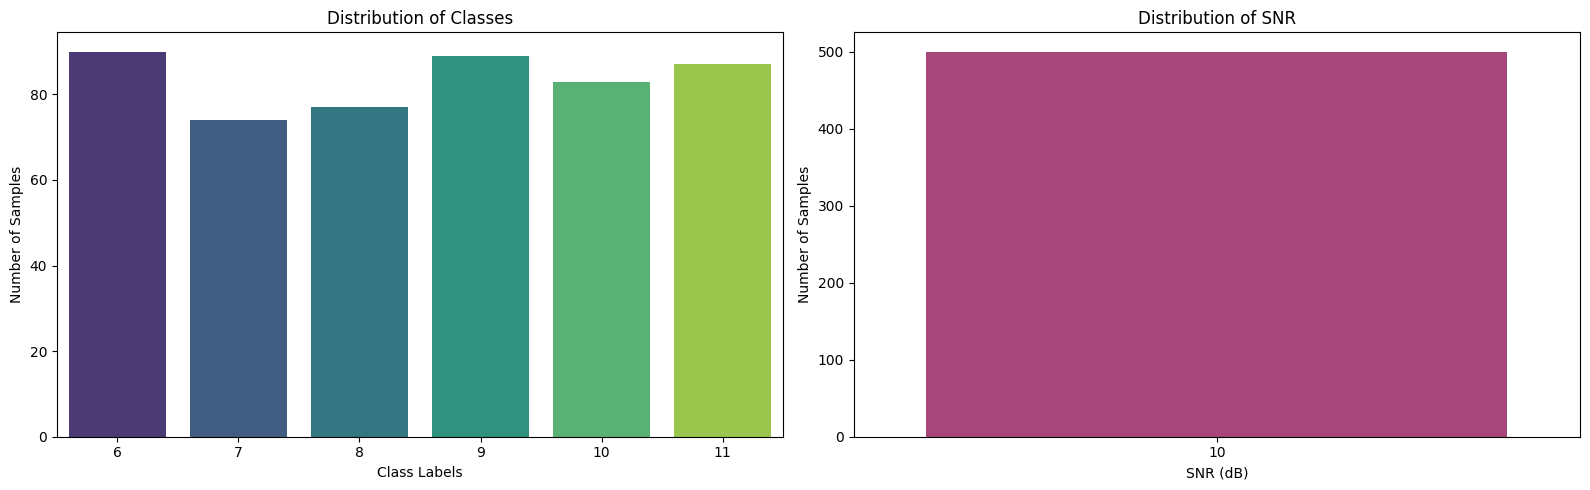

In [9]:
signals, snr, labels_id = load_file(TEST_PATH)
unique_labels, count_labels = np.unique(labels_id, return_counts=True)
unique_snr, count_snr = np.unique(snr, return_counts=True)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(ax=axes[0], x=unique_labels, y=count_labels, palette="viridis")
axes[0].set_title("Distribution of Classes")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Samples")

sns.barplot(ax=axes[1], x=unique_snr, y=count_snr, palette="magma")
axes[1].set_title("Distribution of SNR")
axes[1].set_xlabel("SNR (dB)")
axes[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()

### Visualisations

In [10]:
def inspect_dataset(path):
    with h5py.File(path, "r") as f:
        X = f["signaux"]
        y = f["labels"]

        print("Shape des signaux :", X.shape)
        print("Shape des labels :", y.shape)
        print("Type des signaux :", X.dtype)
        print("Type des labels :", y.dtype)
        print("Exemple signal shape :", X[0].shape)

inspect_dataset(paths["train"])
inspect_dataset(paths["enroll"])
inspect_dataset(paths["test"])


Shape des signaux : (30000, 2048, 2)
Shape des labels : (30000,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)


In [11]:
def count_classes(path):
    with h5py.File(path, "r") as f:
        labels = f["labels"][:]
    counts = Counter(labels)
    return dict(counts)

print("\nDistribution train :", count_classes(paths["train"]))
print("Distribution enroll :", count_classes(paths["enroll"]))
print("Distribution test :", count_classes(paths["test"]))


Distribution train : {np.int8(4): 4894, np.int8(3): 4867, np.int8(5): 5075, np.int8(2): 5053, np.int8(1): 4968, np.int8(0): 5143}
Distribution enroll : {np.int8(7): 99, np.int8(8): 78, np.int8(11): 89, np.int8(10): 75, np.int8(9): 66, np.int8(6): 93}
Distribution test : {np.int8(11): 87, np.int8(6): 90, np.int8(8): 77, np.int8(10): 83, np.int8(7): 74, np.int8(9): 89}


In [12]:
def plot_examples(path, classes_to_show, n=3):
    with h5py.File(path, "r") as f:
        X = f["signaux"][:]
        y = f["labels"][:]

    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes_to_show:
        samples = X[y == cls][:n]
        for s in samples:
            plt.subplot(len(classes_to_show), n, idx)
            plt.plot(s)
            plt.title(f"Classe {cls}")
            plt.tight_layout()
            idx += 1

#### Train

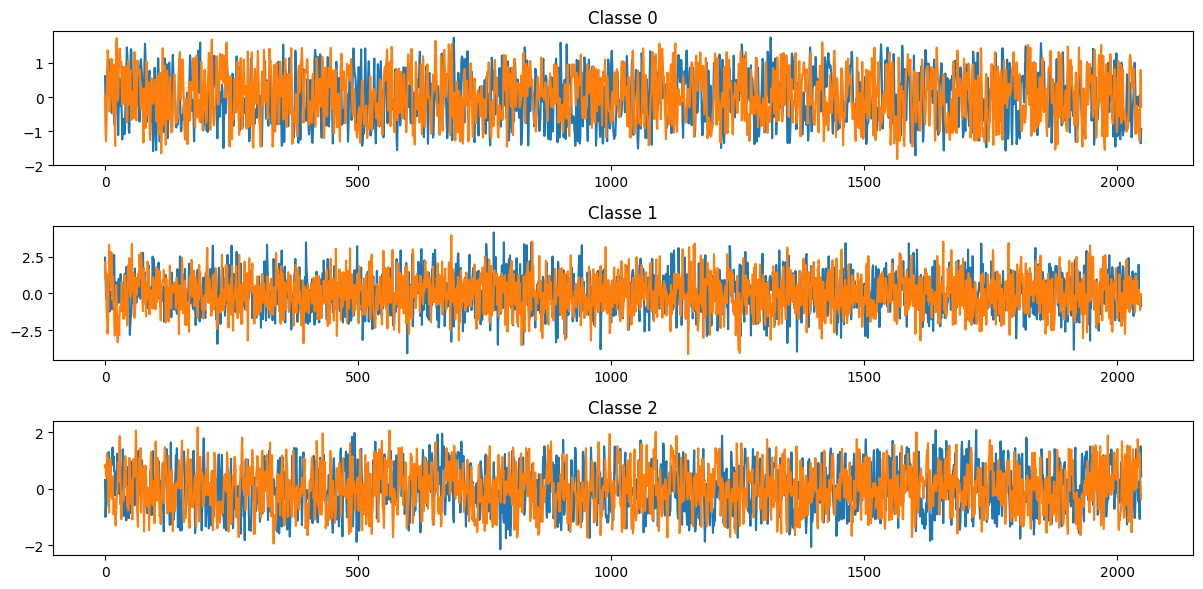

In [13]:
plot_examples(paths["train"], classes_to_show=[0,1,2], n=1)

#### Enroll

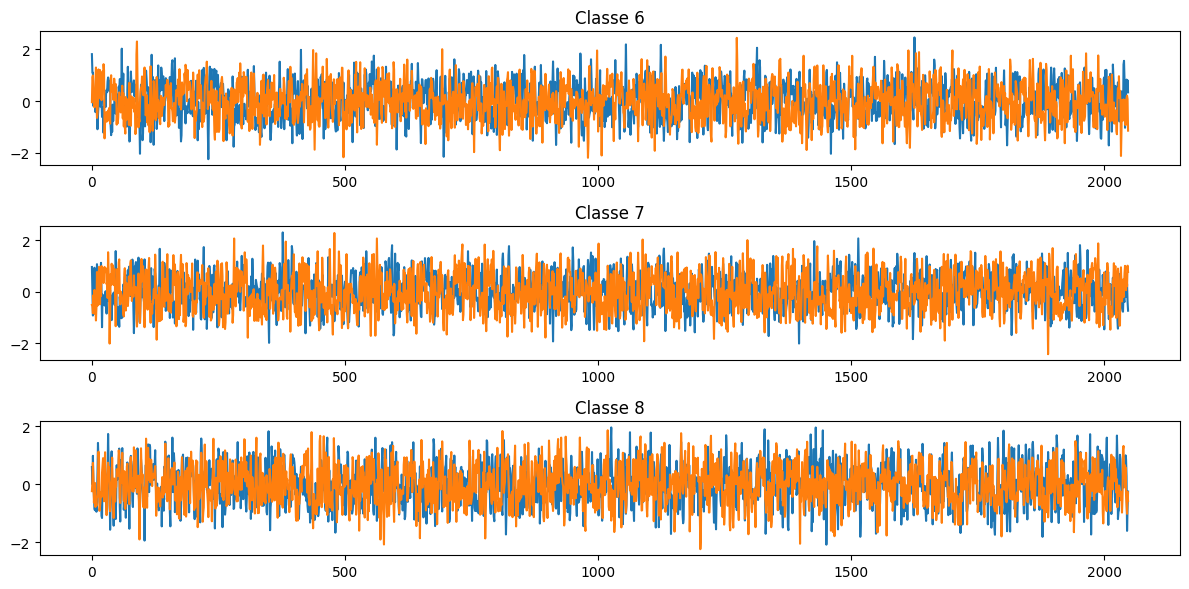

In [14]:
plot_examples(paths["enroll"], classes_to_show=[6,7,8], n=1)

## Dataloaders

In [15]:
class BasicDataset(Dataset):
    def __init__(self, signals, labels, transform=None):
        self.signals = signals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]
        y = self.labels[idx]

        x = torch.tensor(x, dtype=torch.float32)
        x = x.permute(1,0)

        return x, torch.tensor(y, dtype=torch.long)



In [16]:
X, _, y = load_file(TRAIN_PATH)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)



In [17]:
print("Shape X :", X_train.shape)
print("Shape y :", y_train.shape)
print("Classes :", np.unique(y_train))


Shape X : (27000, 2048, 2)
Shape y : (27000,)
Classes : [0 1 2 3 4 5]


In [18]:
train_dataset = BasicDataset(X_train, y_train)
val_dataset   = BasicDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Pipeline

### First approach

#### Simple model

In [19]:
class SimpleEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.fc = nn.Linear(128, emb_dim)

    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x


class Classifier(nn.Module):
    def __init__(self, encoder, emb_dim=64):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(emb_dim, 6)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.fc(z)
        return logits



In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = SimpleEncoder(emb_dim=64).to(device)
model = Classifier(encoder, emb_dim=64).to(device)

save_path = f"models/simple_model.pth"


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_val += yb.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}\n")


torch.save(model.state_dict(), save_path)
print(f"Modèle sauvegardé dans {save_path}")




Epoch 1/3 [Val]: 100%|██████████| 47/47 [00:00<00:00, 322.19it/s]



Epoch 1/3 | Train Loss: 1.2696 | Train Acc: 0.303 | Val Loss: 1.1234 | Val Acc: 0.340



Epoch 2/3 [Val]: 100%|██████████| 47/47 [00:00<00:00, 320.52it/s]



Epoch 2/3 | Train Loss: 1.1202 | Train Acc: 0.339 | Val Loss: 1.1042 | Val Acc: 0.343



Epoch 3/3 [Val]: 100%|██████████| 47/47 [00:00<00:00, 316.61it/s]



Epoch 3/3 | Train Loss: 1.1076 | Train Acc: 0.345 | Val Loss: 1.1356 | Val Acc: 0.338

Modèle sauvegardé dans models/simple_model.pth


#### Few shot learning

In [23]:
encoder = SimpleEncoder(emb_dim=64)
model = Classifier(encoder, emb_dim=64)

model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()


Classifier(
  (encoder): SimpleEncoder(
    (cnn): Sequential(
      (0): Conv1d(2, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (5): ReLU()
      (6): AdaptiveAvgPool1d(output_size=1)
    )
    (fc): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [24]:
encoder = model.encoder
encoder.eval()
encoder.to(device)

SimpleEncoder(
  (cnn): Sequential(
    (0): Conv1d(2, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=128, out_features=64, bias=True)
)

In [21]:
X_few_shot, _, y_few_shot = load_file(ENROLL_PATH)
X_test, _, y_test = load_file(TEST_PATH)

X_few_shot = torch.tensor(X_few_shot, dtype=torch.float32).permute(0,2,1)
y_few_shot = torch.tensor(y_few_shot, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).permute(0,2,1)
y_test = torch.tensor(y_test, dtype=torch.long)


def sample_k_per_class(X, y, k):
    Xk, yk = [], []
    classes = torch.unique(y)

    for c in classes:
        idx = torch.where(y == c)[0]
        chosen = idx[torch.randperm(len(idx))[:k]]
        Xk.append(X[chosen])
        yk.append(y[chosen])

    return torch.cat(Xk), torch.cat(yk)

X_few_shot, y_few_shot = sample_k_per_class(X_few_shot, y_few_shot, k=1)




In [25]:
def compute_prototypes(encoder, X, y):
    encoder.eval()
    classes = torch.unique(y)
    protos = []
    labels = []

    with torch.no_grad():
        for c in classes:
            Xc = X[y == c].to(device)
            z = encoder(Xc)
            proto = z.mean(dim=0)
            protos.append(proto)
            labels.append(c)

    return torch.stack(protos), torch.tensor(labels)

prototypes, proto_labels = compute_prototypes(encoder, X_few_shot, y_few_shot)


def classify(encoder, X_test, prototypes, proto_labels):
    encoder.eval()
    preds = []

    with torch.no_grad():
        z = encoder(X_test.to(device))
        dists = torch.cdist(z, prototypes)
        pred_idx = dists.argmin(dim=1)
        preds = proto_labels.to(pred_idx.device)[pred_idx]

    return preds


preds = classify(encoder, X_test, prototypes, proto_labels)
acc = (preds.cpu() == y_test).float().mean()
print("Few-shot accuracy :", acc.item())





Few-shot accuracy : 0.31200000643730164


#### Benchmark

In [26]:
from sklearn.metrics import confusion_matrix

def sample_task(X, y, k_shot=1, n_query=20):
    classes = torch.unique(y)
    X_support, y_support = [], []
    X_query, y_query = [], []

    for c in classes:
        idx = torch.where(y == c)[0]
        perm = idx[torch.randperm(len(idx))]

        support_idx = perm[:k_shot]
        query_idx   = perm[k_shot:k_shot + n_query]

        X_support.append(X[support_idx])
        y_support.append(y[support_idx])

        X_query.append(X[query_idx])
        y_query.append(y[query_idx])

    return (
        torch.cat(X_support),
        torch.cat(y_support),
        torch.cat(X_query),
        torch.cat(y_query)
    )


def benchmark_few_shot(encoder, X, y, n_tasks=1000, k_shot=1, n_query=20):

    all_preds = []
    all_true  = []
    accs = []

    for t in range(n_tasks):

        Xs, ys, Xq, yq = sample_task(X, y, k_shot=k_shot, n_query=n_query)

        prototypes, proto_labels = compute_prototypes(encoder, Xs, ys)
        preds = classify(encoder, Xq, prototypes, proto_labels)

        acc = (preds.cpu() == yq.cpu()).float().mean().item()
        accs.append(acc)

        all_preds.append(preds.cpu())
        all_true.append(yq.cpu())

        if (t+1) % 50 == 0:
            print(f"[{t+1}/{n_tasks}]  mean acc = {np.mean(accs):.3f}")

    all_preds = torch.cat(all_preds)
    all_true = torch.cat(all_true)

    cm = confusion_matrix(all_true.numpy(), all_preds.numpy(),
                          labels=torch.unique(y).numpy())

    return np.mean(accs), np.std(accs), cm

In [27]:
results = {}

for k_shot in [1, 3, 5, 10]:
    mean_acc, std_acc, cm = benchmark_few_shot(
        encoder,
        X_test,
        y_test,
        n_tasks=100,
        k_shot=k_shot,
        n_query=20
    )

    results[k_shot] = {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "cm": cm
    }

    print(f"k={k_shot} | Mean accuracy: {mean_acc:.4f} | Std: {std_acc:.4f}")


[50/100]  mean acc = 0.246
[100/100]  mean acc = 0.252
k=1 | Mean accuracy: 0.2524 | Std: 0.0604
[50/100]  mean acc = 0.294
[100/100]  mean acc = 0.295
k=3 | Mean accuracy: 0.2954 | Std: 0.0504
[50/100]  mean acc = 0.310
[100/100]  mean acc = 0.302
k=5 | Mean accuracy: 0.3017 | Std: 0.0423
[50/100]  mean acc = 0.318
[100/100]  mean acc = 0.312
k=10 | Mean accuracy: 0.3123 | Std: 0.0368


#### Results

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

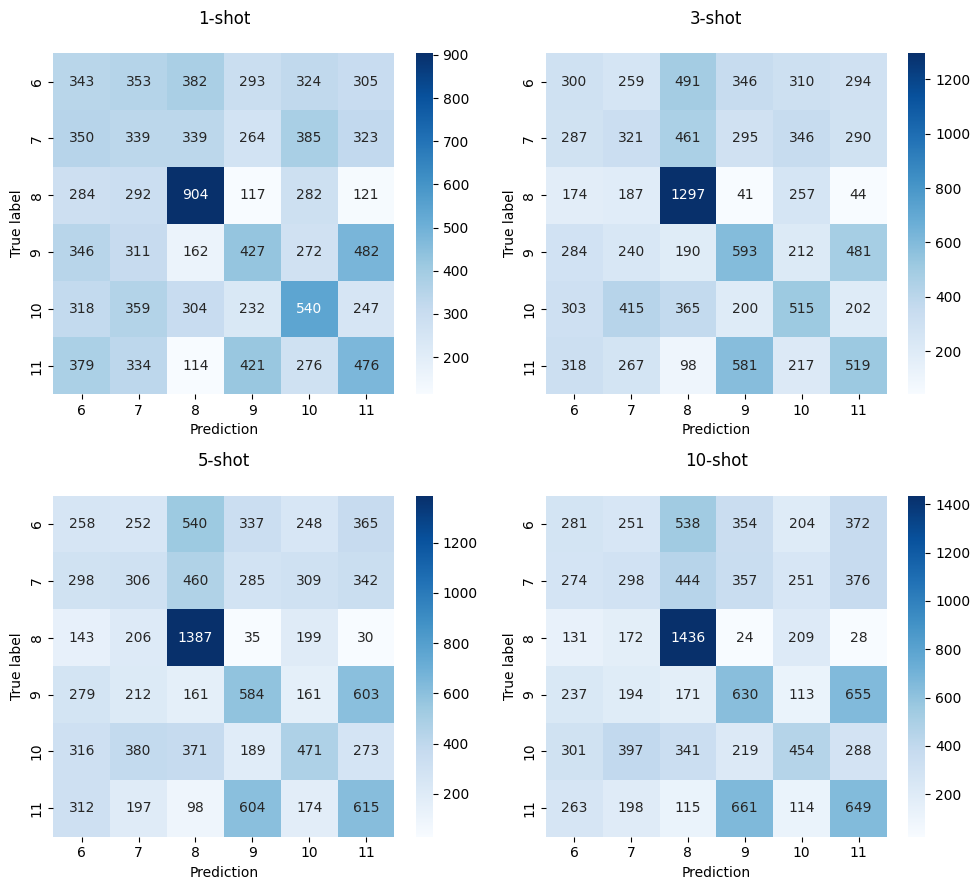

In [30]:
k_shots = [1, 3, 5, 10]
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i, k_shot in enumerate(k_shots):
    cm = results[k_shot]["cm"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[6, 7, 8, 9, 10, 11],
        yticklabels=[6, 7, 8, 9, 10, 11],
        ax=axes[i]
    )

    axes[i].set_title(
        f"{k_shot}-shot\n"
    )
    axes[i].set_xlabel("Prediction")
    axes[i].set_ylabel("True label")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


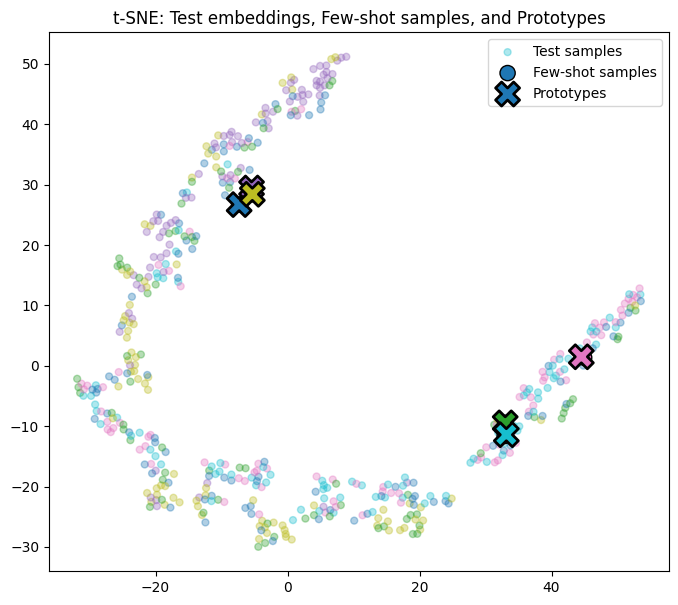

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

encoder.eval()

with torch.no_grad():
    Z_test = encoder(X_test.to(device)).cpu()
    Z_few  = encoder(X_few_shot.to(device)).cpu()
    Z_proto = prototypes.cpu()

Z_all = torch.cat([Z_test, Z_few, Z_proto], dim=0)

labels_all = torch.cat([
    y_test.cpu(),
    y_few_shot.cpu(),
    proto_labels.cpu()
])


point_type = torch.cat([
    torch.zeros(len(Z_test)),
    torch.ones(len(Z_few)),
    torch.ones(len(Z_proto)) * 2
])

tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=200,
    n_iter=2000,
    init="pca"
)

Z_2D = tsne.fit_transform(Z_all.numpy())


plt.figure(figsize=(8, 7))


mask_test = (point_type == 0)
plt.scatter(
    Z_2D[mask_test, 0], Z_2D[mask_test, 1],
    c=labels_all[mask_test], cmap="tab10",
    alpha=0.35, s=25,
    label="Test samples"
)


mask_few = (point_type == 1)
plt.scatter(
    Z_2D[mask_few, 0], Z_2D[mask_few, 1],
    c=labels_all[mask_few], cmap="tab10",
    edgecolors="black", linewidths=1,
    s=120, marker="o",
    label="Few-shot samples"
)


mask_proto = (point_type == 2)
plt.scatter(
    Z_2D[mask_proto, 0], Z_2D[mask_proto, 1],
    c=labels_all[mask_proto], cmap="tab10",
    marker="X", edgecolors="black",
    linewidths=2, s=300,
    label="Prototypes"
)

plt.title("t-SNE: Test embeddings, Few-shot samples, and Prototypes")
plt.legend()
plt.show()


### Second approach

#### Definition: Episode

##### Pick (N=3) classes (3-way):
These classes are called the task for the episode

##### For each classes chosen:
- **Support set:** Pick randomly S examples (S=1 for 1-shot, S=5 for 5-shot)
- **Query set:** Pick randomly Q different examples (Q=15).

So the task of the Episode is to learn from the support set (3 data, 1 per class) to correctly classify the query set (45 unseen data)

#### Algorihtm
For 1-shot learning

- Support phase
- Query phase
- Backpropagation

### Support phase

<code>- support_embeddings = CNN(support_signals)  // shape: [3, 64]

&nbsp;&nbsp;&nbsp;&nbsp;prototype_0 = support_embeddings[class_0_index]  // shape: [64]
    
&nbsp;&nbsp;&nbsp;&nbsp;prototype_1 = support_embeddings[class_1_index]  // shape: [64]
&nbsp;&nbsp;&nbsp;&nbsp;... // 3 prototypes total
&nbsp;&nbsp;&nbsp;&nbsp;(we take the mean for k>1)



### Query phase

- query_embeddings = CNN(query_signals)      // shape: [45, 64]

&nbsp;&nbsp;&nbsp;&nbsp;<b>Take query embedding q</b> (shape: [64])
    
&nbsp;&nbsp;&nbsp;&nbsp;distances = []
    
&nbsp;&nbsp;&nbsp;&nbsp;for each prototype p:
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;d = ||q - p||²  // squared Euclidean distance
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;distances.append(d)
    
&nbsp;&nbsp;&nbsp;&nbsp;<b>distances = [d_0, d_1, d_2]</b>
    
&nbsp;&nbsp;&nbsp;&nbsp;<b>Convert to probabilities (softmax over negative distances)</b>
    
&nbsp;&nbsp;&nbsp;&nbsp;probs = softmax([-d_0, -d_1, -d_2])
    
&nbsp;&nbsp;&nbsp;&nbsp;<b>probs = [p_0, p_1, p_2] summing to 1.0</b>
    
&nbsp;&nbsp;&nbsp;&nbsp;<b>True label: say it's class 0 </b>
    
&nbsp;&nbsp;&nbsp;&nbsp;loss_for_this_query = -log(p_0)


total_loss = 0
    
for each query_signal in 45_queries:
    
&nbsp;&nbsp;&nbsp;&nbsp;total_loss += -log(p_correct_class_for_this_query)  + $\alpha$ log(1-p_incorect_class_for_this_query)

average_loss = total_loss / 45</code>





### Backpropagation

∂Loss/∂d_0 = p_0 - 1  # Negative gradient (because p_0 should be 1 but is <1)

∂Loss/∂d_1 = p_1 - 0  # Positive gradient (because p_1 should be 0 but is >0)



∂d/∂q = 2*(q - p)   # Gradient w.r.t. query embedding

∂d/∂p = 2*(p - q)   # Gradient w.r.t. prototype embedding

#### Remarks

##### Euclidean Distance > Cosine Distance
Euclidean Distance caracterizes angle (direction) and and magnitude whereas Cosine focus nly on directio (angle).

##### High-Way
The higher the number of way is the better our algorithm performs, in other words the more there are different classes learned in the trained the more our algorithm is able to identify new classes quickly.

#### Mean for prototypes
There's not enough data to reliably estimate multiple clusters. A single mean is the most stable statistic (only 1-5 examples) and our encoder adapts itself to this mean.

#### Zero-shot Learning

<pre>
signal Space    --------->  f_φ  --------->  [0.23, -0.45, 0.89, ...]  <-- signal Embedding
                                                     |
                                                     | Compare distances!
Shared Embedding Space  <----------------------------|
                     (Semantic Alignment)            |
                                                     |
Text Space     --------->  g_θ  --------->  [0.19, -0.42, 0.91, ...]  <-- Text Embedding
</pre>

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Dict, Optional
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


class SignalPrototypicalNetwork(nn.Module):
    def __init__(self, embedding_dim: int = 64, dropout_rate: float = 0.3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate

        # Define the embedding network for I/Q signals (2 channels)
        self.embedding_net = self._build_embedding_network()

        # Initialize weights
        self._initialize_weights()

    def _build_embedding_network(self) -> nn.Module:
        return nn.Sequential(
            # First convolutional block
            nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),

            # Second convolutional block
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),

            # Third convolutional block
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),

            # Fourth convolutional block
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),

            # Global pooling and linear layer
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, self.embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, support_signals: torch.Tensor,
                support_labels: torch.Tensor,
                query_signals: torch.Tensor,
                n_way: int, n_shot: int) -> torch.Tensor:

        # Reshape to [batch, channels, length] for Conv1d
        support_signals = support_signals.permute(0, 2, 1)
        query_signals = query_signals.permute(0, 2, 1)

        # Embed all signals
        support_embeddings = self.embedding_net(support_signals)
        query_embeddings = self.embedding_net(query_signals)

        # Compute prototypes for each class
        prototypes = self.compute_prototypes(support_embeddings, support_labels, n_way)
        #here we only do the mean on the support embedding as it was shown as optimal by the paper

        # Compute distances: squared Euclidean distance
        # Expand dimensions for broadcasting
        query_expanded = query_embeddings.unsqueeze(1)
        prototypes_expanded = prototypes.unsqueeze(0)

        # Squared Euclidean distance
        distances = torch.sum((query_expanded - prototypes_expanded) ** 2, dim=2)

        # Convert distances to logits (negative distances)
        logits = -distances

        return logits

    def compute_prototypes(self, support_set: torch.Tensor,
                          support_labels: torch.Tensor,
                          n_way: int) -> torch.Tensor:

        prototypes = []

        for class_idx in range(n_way):
            # Get embeddings for this class
            class_mask = (support_labels == class_idx)
            if class_mask.sum() == 0:
                # No examples for this class (shouldn't happen)
                prototypes.append(torch.zeros(self.embedding_dim))
                continue

            class_embeddings = support_set[class_mask]

            # Prototype = mean of embeddings for this class
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)

        return torch.stack(prototypes)


    def evaluate_few_shot(self, enroll_signals: torch.Tensor,
                         enroll_labels: torch.Tensor,
                         test_signals: torch.Tensor,
                         test_labels: torch.Tensor,
                         n_way: int,
                         n_shot: int,
                         n_trials: int = 100) -> Tuple[float, float, List[float]]:

        self.eval()

        accuracies = []

        for trial in range(n_trials):
            # Sample n_way classes from the available new classes (6-11)
            unique_classes = torch.unique(enroll_labels)
            if len(unique_classes) < n_way:
                # Not enough classes for n_way test
                continue

            selected_classes = np.random.choice(unique_classes.cpu().numpy(),
                                               size=n_way, replace=False)

            support_signals_list = []
            support_labels_list = []
            query_signals_list = []
            query_labels_list = []

            for i, class_id in enumerate(selected_classes):
                # Get enrollment signals for this class
                class_mask = (enroll_labels == class_id)
                class_enroll_signals = enroll_signals[class_mask]

                # Get test signals for this class
                test_class_mask = (test_labels == class_id)
                test_class_signals = test_signals[test_class_mask]

                # Check if we have enough data
                if len(class_enroll_signals) < n_shot or len(test_class_signals) < 5:
                    continue

                # Randomly select support examples
                enroll_indices = np.random.choice(len(class_enroll_signals), n_shot, replace=False)
                support_signals_list.append(class_enroll_signals[enroll_indices])
                support_labels_list.append(torch.full((n_shot,), i, dtype=torch.long))

                # Sample query examples (5 per class as in the paper)
                n_query_per_class = min(5, len(test_class_signals))
                query_indices = np.random.choice(len(test_class_signals), n_query_per_class, replace=False)
                query_signals_list.append(test_class_signals[query_indices])
                query_labels_list.append(torch.full((n_query_per_class,), i, dtype=torch.long))

            if len(support_signals_list) == 0:
                continue

            support_signals = torch.cat(support_signals_list, dim=0)
            support_labels = torch.cat(support_labels_list, dim=0)
            query_signals = torch.cat(query_signals_list, dim=0)
            query_labels = torch.cat(query_labels_list, dim=0)

            # Forward pass (no gradients)
            with torch.no_grad():
                logits = self.forward(support_signals, support_labels,
                                     query_signals, n_way, n_shot)
                predictions = torch.argmax(logits, dim=1)
                accuracy = (predictions == query_labels).float().mean().item()

            accuracies.append(accuracy)

        if len(accuracies) == 0:
            return 0.0, 0.0, []

        avg_accuracy = np.mean(accuracies) * 100
        conf_interval = 1.96 * np.std(accuracies) / np.sqrt(len(accuracies)) * 100

        return avg_accuracy, conf_interval, accuracies

    def get_embeddings(self, signals: torch.Tensor) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            signals = signals.permute(0, 2, 1)
            embeddings = self.embedding_net(signals)
        return embeddings.cpu().numpy()

    def set_episode_params(self, n_way: int, n_shot: int):
        self.n_way = n_way
        self.n_shot = n_shot

In [ ]:
def train_simple_episodic():

    # Load data
    with h5py.File(TRAIN_PATH, 'r') as f:
        base_signals = torch.FloatTensor(f['signaux'][:])
        base_labels = torch.LongTensor(f['labels'][:])

    with h5py.File(ENROLL_PATH, 'r') as f:
        enroll_signals = torch.FloatTensor(f['signaux'][:])
        enroll_labels = torch.LongTensor(f['labels'][:]) - 6

    with h5py.File(TEST_PATH, 'r') as f:
        test_signals = torch.FloatTensor(f['signaux'][:])
        test_labels = torch.LongTensor(f['labels'][:]) - 6

    print(f"Data loaded: {len(base_signals)} train, {len(enroll_signals)} enroll, {len(test_signals)} test")

    # Model
    model = SignalPrototypicalNetwork()
    optimizer = torch.optim.Adam(model.embedding_net.parameters(), lr=1e-5)
    losses=[]
    accuracies=[]
    # Training
    n_way = 6
    n_shot = 5
    n_query = 10
    n_episodes = 2000

    print(f"\nTraining {n_way}-way {n_shot}-shot for {n_episodes} episodes...")

    for episode in range(n_episodes):
        optimizer.zero_grad()

        # Create episode: sample n_way random classes
        unique_classes = torch.unique(base_labels)
        selected_classes = np.random.choice(unique_classes.numpy(), n_way, replace=False)

        support_data = []
        support_labels = []
        query_data = []
        query_labels = []

        for i, cls in enumerate(selected_classes):
            # Get indices for this class
            idx = torch.where(base_labels == cls)[0]

            # Sample support and query
            if len(idx) < n_shot + n_query:
                # Not enough data - sample with replacement
                chosen = idx[torch.randint(0, len(idx), (n_shot + n_query,))]
            else:
                chosen = idx[torch.randperm(len(idx))[:n_shot + n_query]]

            support = chosen[:n_shot]
            query = chosen[n_shot:n_shot + n_query]

            support_data.append(base_signals[support])
            support_labels.append(torch.full((n_shot,), i))
            query_data.append(base_signals[query])
            query_labels.append(torch.full((n_query,), i))

        # Stack everything
        support_signals = torch.cat(support_data, dim=0)
        support_labels = torch.cat(support_labels, dim=0)
        query_signals = torch.cat(query_data, dim=0)
        query_labels = torch.cat(query_labels, dim=0)

        # Forward pass
        logits = model.forward(support_signals, support_labels, query_signals, n_way, n_shot)

        # Loss and backward
        loss = F.cross_entropy(logits, query_labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc = (logits.argmax(1) == query_labels).float().mean()
        accuracies.append(acc.item())

        if (episode + 1) % 100 == 0:
            acc = (logits.argmax(1) == query_labels).float().mean()
            print(f"Episode {episode+1}: loss={loss.item():.4f}, acc={acc.item():.2%}")

    print("\nTraining complete! Evaluating on new classes...")

    # Evaluation
    results = {}
    for n_shot in [1, 3, 5, 10]:
        print(f"\n{n_shot}-shot evaluation:")

        # Use your evaluate_few_shot method
        acc, ci, _ = model.evaluate_few_shot(
            enroll_signals, enroll_labels,
            test_signals, test_labels,
            n_way=6,
            n_shot=n_shot,
            n_trials=50
        )

        results[f'{n_shot}-shot'] = {'accuracy': acc, 'conf_interval': ci}
        print(f"  Accuracy: {acc:.2f}% ±{ci:.2f}%")

    return model, results, losses, accuracies


if __name__ == "__main__":
    print("="*80)
    print("FEW-SHOT SIGNAL CLASSIFICATION WITH PROTOTYPICAL NETWORKS")
    print("Based on: J. Snell et al., Prototypical Networks for Few-shot Learning")
    print("="*80)


    # Use the simple version
    model, results, Loss, ac = train_simple_episodic()
    plt.plot([i for i in range(len(Loss))],Loss)
    plt.title("Loss")
    plt.show()
    plt.plot([i for i in range(len(ac))],ac)
    plt.title("Accuracy")
    plt.show()



FEW-SHOT SIGNAL CLASSIFICATION WITH PROTOTYPICAL NETWORKS
Based on: J. Snell et al., Prototypical Networks for Few-shot Learning
Data loaded: 30000 train, 500 enroll, 500 test

Training 6-way 5-shot for 2000 episodes...
Episode 100: loss=1.7534, acc=18.33%
Episode 200: loss=1.5683, acc=33.33%
Episode 300: loss=1.3655, acc=35.00%
Episode 400: loss=1.2373, acc=36.67%
Episode 500: loss=1.2623, acc=33.33%


KeyboardInterrupt: 

In [ ]:
plt.plot([i for i in range(len(ac))],ac)
plt.title("Accuracy")
plt.show()

In [33]:
checkpoint = torch.load('models/signal_prototypical_model.pth', weights_only=False)

model_loaded = torch.load('models/signal_prototypical_model.pth', weights_only=False)
model_loaded.eval()

SignalPrototypicalNetwork(
  (embedding_net): Sequential(
    (0): Conv1d(2, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, af

#### Results

Generating confusion matrix...


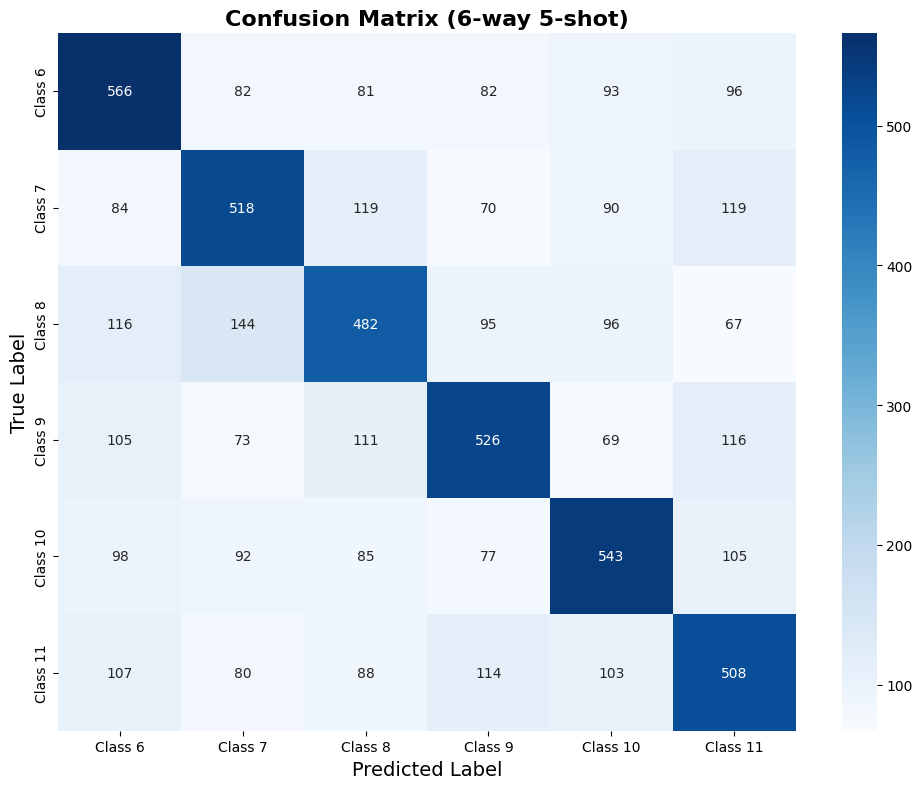

Overall Accuracy: 52.38%
Confusion Matrix Shape: (6, 6)

Per-class accuracy:
  Class 0: 56.60%
  Class 1: 51.80%
  Class 2: 48.20%
  Class 3: 52.60%
  Class 4: 54.30%
  Class 5: 50.80%


In [34]:
from sklearn.preprocessing import StandardScaler

checkpoint = torch.load('models/signal_prototypical_model.pth', weights_only=False)

model_loaded = torch.load('models/signal_prototypical_model.pth', weights_only=False)
model_loaded.eval()


with h5py.File(ENROLL_PATH, 'r') as f:
    enroll_signals = torch.FloatTensor(f['signaux'][:])
    enroll_labels = torch.LongTensor(f['labels'][:]) - 6

with h5py.File(TEST_PATH, 'r') as f:
    test_signals = torch.FloatTensor(f['signaux'][:])
    test_labels = torch.LongTensor(f['labels'][:]) - 6

model_loaded.eval()

def plot_confusion_matrix(model, n_way=6, n_shot=5, n_trials=100):
    print("Generating confusion matrix...")

    all_true_labels = []
    all_pred_labels = []

    for trial in range(n_trials):
        unique_classes = torch.unique(enroll_labels)
        if len(unique_classes) < n_way:
            continue

        selected_classes = np.random.choice(unique_classes.cpu().numpy(),
                                           size=n_way, replace=False)

        support_signals_list = []
        support_labels_list = []
        query_signals_list = []
        query_labels_list = []
        true_class_ids = []

        for i, class_id in enumerate(selected_classes):
            # Get enrollment signals for this class
            class_mask = (enroll_labels == class_id)
            class_enroll_signals = enroll_signals[class_mask]

            # Get test signals for this class
            test_class_mask = (test_labels == class_id)
            test_class_signals = test_signals[test_class_mask]

            # Check if we have enough data
            if len(class_enroll_signals) < n_shot or len(test_class_signals) < 5:
                continue

            # Randomly select support examples
            enroll_indices = np.random.choice(len(class_enroll_signals), n_shot, replace=False)
            support_signals_list.append(class_enroll_signals[enroll_indices])
            support_labels_list.append(torch.full((n_shot,), i, dtype=torch.long))

            # Sample query examples
            n_query_per_class = min(5, len(test_class_signals))
            query_indices = np.random.choice(len(test_class_signals), n_query_per_class, replace=False)
            query_signals_list.append(test_class_signals[query_indices])
            query_labels_list.append(torch.full((n_query_per_class,), i, dtype=torch.long))
            true_class_ids.append(class_id)

        if len(support_signals_list) == 0:
            continue

        support_signals = torch.cat(support_signals_list, dim=0)
        support_labels = torch.cat(support_labels_list, dim=0)
        query_signals = torch.cat(query_signals_list, dim=0)
        query_labels = torch.cat(query_labels_list, dim=0)

        # Get predictions
        with torch.no_grad():
            logits = model.forward(support_signals, support_labels,
                                 query_signals, n_way, n_shot)
            predictions = torch.argmax(logits, dim=1)

        # Map predictions back to original class IDs
        pred_class_ids = []
        for pred_idx in predictions.cpu().numpy():
            if pred_idx < len(true_class_ids):
                pred_class_ids.append(true_class_ids[pred_idx])

        # Store for confusion matrix
        all_true_labels.extend(query_labels.cpu().numpy())
        all_pred_labels.extend(predictions.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels,
                         labels=list(range(n_way)))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {6+i}' for i in range(n_way)],
                yticklabels=[f'Class {6+i}' for i in range(n_way)])
    plt.title(f'Confusion Matrix ({n_way}-way {n_shot}-shot)', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy metrics
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"Confusion Matrix Shape: {cm.shape}")

    # Print per-class accuracy
    print("\nPer-class accuracy:")
    for i in range(n_way):
        if np.sum(cm[i, :]) > 0:
            class_acc = cm[i, i] / np.sum(cm[i, :])
            print(f"  Class {i}: {class_acc:.2%}")

    return cm

# Plot confusion matrix for 5-shot 6-way
conf_matrix = plot_confusion_matrix(model_loaded, n_way=6, n_shot=5, n_trials=200)


Generating embedding space visualization...
Total samples for t-SNE: 300
Embedding dimension: 64
Running t-SNE...


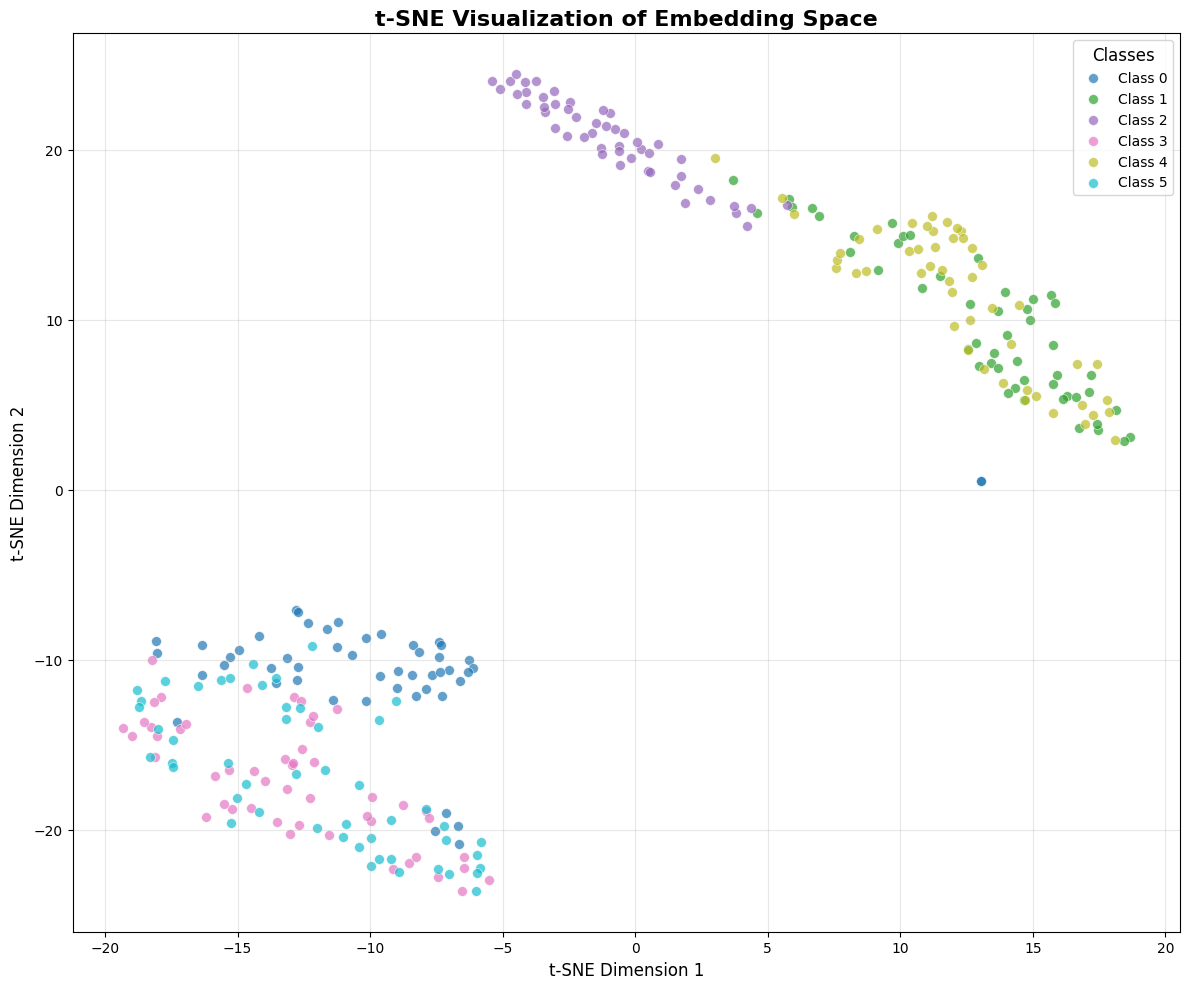


Embedding space statistics:
Number of unique classes: 6
t-SNE perplexity: 30
t-SNE iterations: 1000


In [35]:
def plot_embeddings(model, num_samples_per_class=100):
    print("\nGenerating embedding space visualization...")

    # Get all unique classes
    unique_classes = torch.unique(enroll_labels)

    embeddings_list = []
    labels_list = []
    class_names = []

    # Sample data from each class
    for class_id in unique_classes:
        # Get signals for this class from test set
        class_mask = (test_labels == class_id)
        class_signals = test_signals[class_mask]

        # Limit number of samples
        n_samples = min(num_samples_per_class, len(class_signals))
        if n_samples == 0:
            continue

        indices = np.random.choice(len(class_signals), n_samples, replace=False)
        class_samples = class_signals[indices]

        # Get embeddings
        with torch.no_grad():
            class_embeddings = model.get_embeddings(class_samples)

        embeddings_list.append(class_embeddings)
        labels_list.extend([class_id.item()] * n_samples)
        class_names.append(f'Class {class_id.item()}')

    # Combine all embeddings
    all_embeddings = np.vstack(embeddings_list)
    all_labels = np.array(labels_list)

    print(f"Total samples for t-SNE: {len(all_embeddings)}")
    print(f"Embedding dimension: {all_embeddings.shape[1]}")

    # Standardize embeddings before t-SNE
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(all_embeddings)

    # Apply t-SNE
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30,
                max_iter=1000, learning_rate=200)
    embeddings_2d = tsne.fit_transform(embeddings_scaled)
    # Create color map
    unique_labels = np.unique(all_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot t-SNE visualization
    plt.figure(figsize=(12, 10))

    for i, label in enumerate(unique_labels):
        mask = all_labels == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[colors[i]], label=f'Class {label}',
                   alpha=0.7, s=50, edgecolors='w', linewidth=0.5)

    plt.title('t-SNE Visualization of Embedding Space', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(title='Classes', fontsize=10, title_fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate some statistics
    print("\nEmbedding space statistics:")
    print(f"Number of unique classes: {len(unique_labels)}")
    print(f"t-SNE perplexity: 30")
    print(f"t-SNE iterations: 1000")

    return embeddings_2d, all_labels

# Plot embeddings
embeddings_2d, labels = plot_embeddings(model_loaded, num_samples_per_class=50)




Analyzing distance distribution...


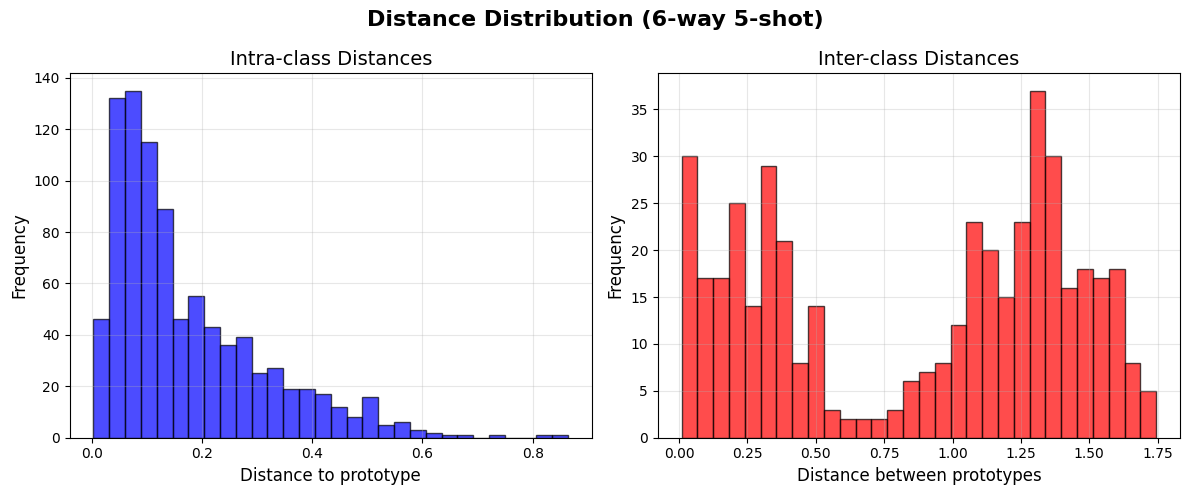

Intra-class distance mean: 0.1726 ± 0.1384
Inter-class distance mean: 0.8721 ± 0.5440
Inter/Intra distance ratio: 5.05

VISUALIZATION COMPLETE


In [36]:
def plot_distance_distribution(model, n_way=6, n_shot=5, n_trials=50):
    """
    Plot intra-class vs inter-class distance distribution
    """
    print("\nAnalyzing distance distribution...")

    intra_distances = []
    inter_distances = []

    for trial in range(n_trials):
        # Create episode
        unique_classes = torch.unique(enroll_labels)
        selected_classes = np.random.choice(unique_classes.cpu().numpy(), n_way, replace=False)

        support_signals_list = []
        support_labels_list = []

        for i, class_id in enumerate(selected_classes):
            class_mask = (enroll_labels == class_id)
            class_enroll_signals = enroll_signals[class_mask]

            if len(class_enroll_signals) < n_shot:
                continue

            enroll_indices = np.random.choice(len(class_enroll_signals), n_shot, replace=False)
            support_signals_list.append(class_enroll_signals[enroll_indices])
            support_labels_list.append(torch.full((n_shot,), i, dtype=torch.long))

        if len(support_signals_list) == 0:
            continue

        support_signals = torch.cat(support_signals_list, dim=0)
        support_labels = torch.cat(support_labels_list, dim=0)

        # Get embeddings
        with torch.no_grad():
            support_signals_conv = support_signals.permute(0, 2, 1)
            embeddings = model.embedding_net(support_signals_conv)

            # Compute prototypes
            prototypes = []
            for i in range(n_way):
                mask = (support_labels == i)
                if torch.sum(mask) > 0:
                    class_embeddings = embeddings[mask]
                    prototype = torch.mean(class_embeddings, dim=0)
                    prototypes.append(prototype)

            if len(prototypes) > 1:
                prototypes = torch.stack(prototypes)

                # Compute intra-class distances (distances to own prototype)
                for i in range(n_way):
                    mask = (support_labels == i)
                    if torch.sum(mask) > 0:
                        class_embeddings = embeddings[mask]
                        distances = torch.norm(class_embeddings - prototypes[i], dim=1)
                        intra_distances.extend(distances.cpu().numpy())

                # Compute inter-class distances (between prototypes)
                for i in range(len(prototypes)):
                    for j in range(i+1, len(prototypes)):
                        distance = torch.norm(prototypes[i] - prototypes[j])
                        inter_distances.append(distance.item())

    # Plot distance distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(intra_distances, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Intra-class Distances', fontsize=14)
    plt.xlabel('Distance to prototype', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(inter_distances, bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.title('Inter-class Distances', fontsize=14)
    plt.xlabel('Distance between prototypes', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.suptitle(f'Distance Distribution ({n_way}-way {n_shot}-shot)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Intra-class distance mean: {np.mean(intra_distances):.4f} ± {np.std(intra_distances):.4f}")
    print(f"Inter-class distance mean: {np.mean(inter_distances):.4f} ± {np.std(inter_distances):.4f}")
    print(f"Inter/Intra distance ratio: {np.mean(inter_distances)/np.mean(intra_distances):.2f}")

# Plot distance distribution (optional)
plot_distance_distribution(model_loaded, n_way=6, n_shot=5, n_trials=30)

print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)

### Third approach

#### Dataloaders

In [37]:
class BasicDataset(Dataset):
    def __init__(self, signals, labels, transform=None):
        self.signals = signals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]
        y = self.labels[idx]

        x = torch.tensor(x, dtype=torch.float32)
        x = x.permute(1,0)

        return x, torch.tensor(y, dtype=torch.long)



In [38]:
X, _, y = load_file(TRAIN_PATH)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)



In [39]:
print("Shape X :", X_train.shape)
print("Shape y :", y_train.shape)
print("Classes :", np.unique(y_train))


Shape X : (27000, 2048, 2)
Shape y : (27000,)
Classes : [0 1 2 3 4 5]


In [40]:
train_dataset = BasicDataset(X_train, y_train)
val_dataset   = BasicDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

#### Model

In [41]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1   = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2   = nn.BatchNorm1d(out_channels)

        self.skip = None
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip is not None:
            identity = self.skip(identity)
        out += identity
        return F.relu(out)


class ResNet1D_SegmentClassifier(nn.Module):
    def __init__(self, n_segments=16, emb_dim=128, n_classes=6):
        super().__init__()

        self.n_segments = n_segments
        self.segment_length = 2048 // n_segments

        # Encodeur de segments
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)

        self.block1 = ResidualBlock1D(64, 64)
        self.block2 = ResidualBlock1D(64, 128, stride=2)
        self.block3 = ResidualBlock1D(128, emb_dim)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(emb_dim, n_classes)

    def encode_segment(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)
        return F.normalize(x, p=2, dim=1)

    def forward(self, x):
        B = x.size(0)
        embeddings = []

        for i in range(self.n_segments):
            start = i * self.segment_length
            end = start + self.segment_length
            seg = x[:, :, start:end]
            z = self.encode_segment(seg)
            embeddings.append(z)

        Z = torch.stack(embeddings, dim=1)

        Z_global = Z.mean(dim=1)

        logits = self.fc(Z_global)

        return logits

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_segments = 16
model = ResNet1D_SegmentClassifier(n_segments=n_segments).to(device)


save_path = f"models/resnet_{n_segments}_segments.pth"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


from tqdm import tqdm

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_val += yb.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}\n")


torch.save(model.state_dict(), save_path)
print(f"Modèle sauvegardé dans {save_path}")




Epoch 1/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 46.23it/s]



Epoch 1/20 | Train Loss: 1.1865 | Train Acc: 0.473 | Val Loss: 0.8511 | Val Acc: 0.600



Epoch 2/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.72it/s]



Epoch 2/20 | Train Loss: 0.7397 | Train Acc: 0.598 | Val Loss: 0.6846 | Val Acc: 0.593



Epoch 3/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 35.55it/s]



Epoch 3/20 | Train Loss: 0.6660 | Train Acc: 0.614 | Val Loss: 0.6536 | Val Acc: 0.602



Epoch 4/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.99it/s]



Epoch 4/20 | Train Loss: 0.6342 | Train Acc: 0.642 | Val Loss: 0.6096 | Val Acc: 0.659



Epoch 5/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.19it/s]



Epoch 5/20 | Train Loss: 0.5774 | Train Acc: 0.697 | Val Loss: 0.5590 | Val Acc: 0.707



Epoch 6/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.64it/s]



Epoch 6/20 | Train Loss: 0.5185 | Train Acc: 0.716 | Val Loss: 0.4957 | Val Acc: 0.723



Epoch 7/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 44.04it/s]



Epoch 7/20 | Train Loss: 0.4837 | Train Acc: 0.728 | Val Loss: 0.4939 | Val Acc: 0.711



Epoch 8/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 46.91it/s]



Epoch 8/20 | Train Loss: 0.4619 | Train Acc: 0.739 | Val Loss: 0.5026 | Val Acc: 0.703



Epoch 9/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.32it/s]



Epoch 9/20 | Train Loss: 0.4526 | Train Acc: 0.744 | Val Loss: 0.4918 | Val Acc: 0.714



Epoch 10/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.97it/s]



Epoch 10/20 | Train Loss: 0.4431 | Train Acc: 0.749 | Val Loss: 0.4778 | Val Acc: 0.721



Epoch 11/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 49.12it/s]



Epoch 11/20 | Train Loss: 0.4319 | Train Acc: 0.772 | Val Loss: 0.4561 | Val Acc: 0.776



Epoch 12/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 35.73it/s]



Epoch 12/20 | Train Loss: 0.4179 | Train Acc: 0.805 | Val Loss: 0.4658 | Val Acc: 0.814



Epoch 13/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.92it/s]



Epoch 13/20 | Train Loss: 0.4043 | Train Acc: 0.832 | Val Loss: 0.5016 | Val Acc: 0.807



Epoch 14/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.15it/s]



Epoch 14/20 | Train Loss: 0.3872 | Train Acc: 0.849 | Val Loss: 0.4442 | Val Acc: 0.817



Epoch 15/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.51it/s]



Epoch 15/20 | Train Loss: 0.3647 | Train Acc: 0.866 | Val Loss: 0.4239 | Val Acc: 0.831



Epoch 16/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.35it/s]



Epoch 16/20 | Train Loss: 0.3401 | Train Acc: 0.876 | Val Loss: 0.4096 | Val Acc: 0.835



Epoch 17/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.64it/s]



Epoch 17/20 | Train Loss: 0.3187 | Train Acc: 0.883 | Val Loss: 0.4247 | Val Acc: 0.814



Epoch 18/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 48.21it/s]



Epoch 18/20 | Train Loss: 0.2965 | Train Acc: 0.893 | Val Loss: 0.4104 | Val Acc: 0.820



Epoch 19/20 [Val]: 100%|██████████| 47/47 [00:01<00:00, 46.65it/s]



Epoch 19/20 | Train Loss: 0.2805 | Train Acc: 0.897 | Val Loss: 0.3802 | Val Acc: 0.836



Epoch 20/20 [Val]: 100%|██████████| 47/47 [00:00<00:00, 47.76it/s]


Epoch 20/20 | Train Loss: 0.2635 | Train Acc: 0.903 | Val Loss: 0.3874 | Val Acc: 0.827

Modèle sauvegardé dans models/resnet_16_segments.pth


#### Few shot learning

In [43]:
model = ResNet1D_SegmentClassifier(n_classes=6)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

ResNet1D_SegmentClassifier(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock1D(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResidualBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [44]:
class FewShotEncoder(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        self.n_segments = classifier.n_segments
        self.segment_length = classifier.segment_length

        self.conv1 = classifier.conv1
        self.bn1   = classifier.bn1
        self.pool1 = classifier.pool1
        self.block1 = classifier.block1
        self.block2 = classifier.block2
        self.block3 = classifier.block3
        self.global_pool = classifier.global_pool

    def encode_segment(self, seg):
        x = self.pool1(F.relu(self.bn1(self.conv1(seg))))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)
        return F.normalize(x, p=2, dim=1)

    def forward(self, x):
        B, C, L = x.shape
        seg_embs = []

        for i in range(self.n_segments):
            s = i * self.segment_length
            e = s + self.segment_length
            seg = x[:, :, s:e]
            z = self.encode_segment(seg)
            seg_embs.append(z)

        seg_embs = torch.stack(seg_embs, dim=1)

        z_global = seg_embs.mean(dim=1)
        z_global = F.normalize(z_global, p=2, dim=1)

        return z_global


encoder = FewShotEncoder(model)
encoder.to(device)
encoder.eval()



FewShotEncoder(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock1D(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResidualBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequ

In [46]:
X_few_shot, _, y_few_shot = load_file(ENROLL_PATH)
X_test, _, y_test = load_file(TEST_PATH)

print(y_test)

X_few_shot = torch.tensor(X_few_shot, dtype=torch.float32).permute(0,2,1)
y_few_shot = torch.tensor(y_few_shot, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).permute(0,2,1)
y_test = torch.tensor(y_test, dtype=torch.long)

X_few_shot = X_few_shot.to(device)
y_few_shot = y_few_shot.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)



def sample_k_per_class(X, y, k):
    Xk, yk = [], []
    classes = torch.unique(y)

    for c in classes:
        idx = torch.where(y == c)[0]
        chosen = idx[torch.randperm(len(idx))[:k]]
        Xk.append(X[chosen])
        yk.append(y[chosen])

    return torch.cat(Xk), torch.cat(yk)

X_few_shot, y_few_shot = sample_k_per_class(X_few_shot, y_few_shot, k=1)




[11 11  6 11  6  6  8 10  8 10 11  6  7  6  9 10 10  9  7 10 10 10  7 10
 10  7 11  7  6  7  7  8  9 10 11 11 11 10  7  9 10  7  9  8  9  9  9  8
  6 10  7  6  7  9 11 11 11  9  6  9 11  9  6  8  6 10  8  8  7 11  9  8
  8  8 11  8 11  8  6  8  6  6  8 10 10  9 11  9  7 10  7  8  8  8  7  6
  9 10  8 10  9  9  9 11  9 11  8  8  7  9  9  6  7  8  9  7  7 11  7  6
  7  9  9 11 10  9  9  7  9  8  9  8 11  7  6 10 10  7 11 10  9  8  6  7
  9 11 10  6  6  6  7  6  6 11  9  9  7  6  6 10  6  8 10  9 10 11  8  8
  6  6 11  6  7 10  6  9 11 11  7  8  6  9 10 10 10  9 10  6 10  9  9 11
  7 10  8  6  9  7  7 11  9 11  9  9 10  8 11  6  9  6 10 10 11  8 11  8
  6 11  8  8  8  9  6 10 11  8  8 11 10  9  6 11 11  9  8 11  7  9 11  7
  6  7  9  8 10  7  6  8  6  9  7  9  8  9  6  9  7 10 11 10  6  7 11 11
 11  8 11  9  7  8  8  9  6  6  9  8  7 10  7 11  8  6  9 11  6  7  6 11
 11  6  7 11  8  6 11 11  7  6  6 11  7  6  7 10 11 11  7 10  6  7  6  6
 11 11  8  8  9 10  7  6  9  8 10  9 11 10  6  8 11

In [47]:
def compute_prototypes(encoder, X, y):
    encoder.eval()
    classes = torch.unique(y)
    protos = []
    labels = []

    with torch.no_grad():
        for c in classes:
            Xc = X[y == c].to(device)
            z = encoder(Xc)
            proto = z.mean(dim=0)
            protos.append(proto)
            labels.append(c)

    return torch.stack(protos), torch.tensor(labels, device=protos[0].device)

prototypes, proto_labels = compute_prototypes(encoder, X_few_shot, y_few_shot)


def classify(encoder, X_test, prototypes, proto_labels):
    encoder.eval()
    preds = []

    with torch.no_grad():
        z = encoder(X_test.to(device))
        dists = torch.cdist(z, prototypes)
        pred_idx = dists.argmin(dim=1)
        preds = proto_labels[pred_idx]

    return preds


preds = classify(encoder, X_test, prototypes, proto_labels)
acc = (preds == y_test).float().mean()
print("Few-shot accuracy :", acc.item())


Few-shot accuracy : 0.7320000529289246


#### Benchmark

In [53]:
from sklearn.metrics import confusion_matrix


def sample_task(X, y, k_shot=1, n_query=20):
    classes = torch.unique(y)
    X_support, y_support = [], []
    X_query, y_query = [], []

    for c in classes:
        idx = torch.where(y == c)[0]
        perm = idx[torch.randperm(len(idx))]

        support_idx = perm[:k_shot]
        query_idx   = perm[k_shot:k_shot + n_query]

        X_support.append(X[support_idx])
        y_support.append(y[support_idx])

        X_query.append(X[query_idx])
        y_query.append(y[query_idx])

    return (
        torch.cat(X_support, dim=0),
        torch.cat(y_support, dim=0),
        torch.cat(X_query, dim=0),
        torch.cat(y_query, dim=0),
    )


def benchmark_few_shot(
    encoder,
    X,
    y,
    n_tasks=1000,
    k_shot=1,
    n_query=20
):
    encoder.eval()

    all_preds = []
    all_true  = []
    accs = []

    for t in range(n_tasks):

        Xs, ys, Xq, yq = sample_task(X, y, k_shot=k_shot, n_query=n_query)

        prototypes, proto_labels = compute_prototypes(encoder, Xs, ys)
        preds = classify(encoder, Xq, prototypes, proto_labels)

        acc = (preds == yq).float().mean().item()
        accs.append(acc)

        all_preds.append(preds.detach().cpu())
        all_true.append(yq.detach().cpu())

        if (t + 1) % 50 == 0:
            print(f"[{t+1}/{n_tasks}]  mean acc = {np.mean(accs):.3f}")

    all_preds = torch.cat(all_preds, dim=0)
    all_true  = torch.cat(all_true, dim=0)

    labels = torch.unique(y).cpu().numpy()
    cm = confusion_matrix(
        all_true.numpy(),
        all_preds.numpy(),
        labels=labels
    )

    return np.mean(accs), np.std(accs), cm, labels


In [58]:
results = {}

for k_shot in [1, 3, 5, 10]:
    mean_acc, std_acc, cm, labels = benchmark_few_shot(
        encoder,
        X_test,
        y_test,
        n_tasks=500,
        k_shot=k_shot,
        n_query=20
    )

    results[k_shot] = {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "cm": cm,
        "labels": labels
    }

    print(f"k={k_shot} | Mean accuracy: {mean_acc:.4f} | Std: {std_acc:.4f}")


[50/500]  mean acc = 0.733
[100/500]  mean acc = 0.739
[150/500]  mean acc = 0.736
[200/500]  mean acc = 0.740
[250/500]  mean acc = 0.740
[300/500]  mean acc = 0.739
[350/500]  mean acc = 0.739
[400/500]  mean acc = 0.737
[450/500]  mean acc = 0.737
[500/500]  mean acc = 0.737
k=1 | Mean accuracy: 0.7371 | Std: 0.0596
[50/500]  mean acc = 0.782
[100/500]  mean acc = 0.780
[150/500]  mean acc = 0.779
[200/500]  mean acc = 0.777
[250/500]  mean acc = 0.777
[300/500]  mean acc = 0.776
[350/500]  mean acc = 0.776
[400/500]  mean acc = 0.775
[450/500]  mean acc = 0.774
[500/500]  mean acc = 0.774
k=3 | Mean accuracy: 0.7738 | Std: 0.0327
[50/500]  mean acc = 0.780
[100/500]  mean acc = 0.782
[150/500]  mean acc = 0.780
[200/500]  mean acc = 0.781
[250/500]  mean acc = 0.782
[300/500]  mean acc = 0.780
[350/500]  mean acc = 0.780
[400/500]  mean acc = 0.779
[450/500]  mean acc = 0.780
[500/500]  mean acc = 0.781
k=5 | Mean accuracy: 0.7807 | Std: 0.0337
[50/500]  mean acc = 0.783
[100/500] 

#### Results

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

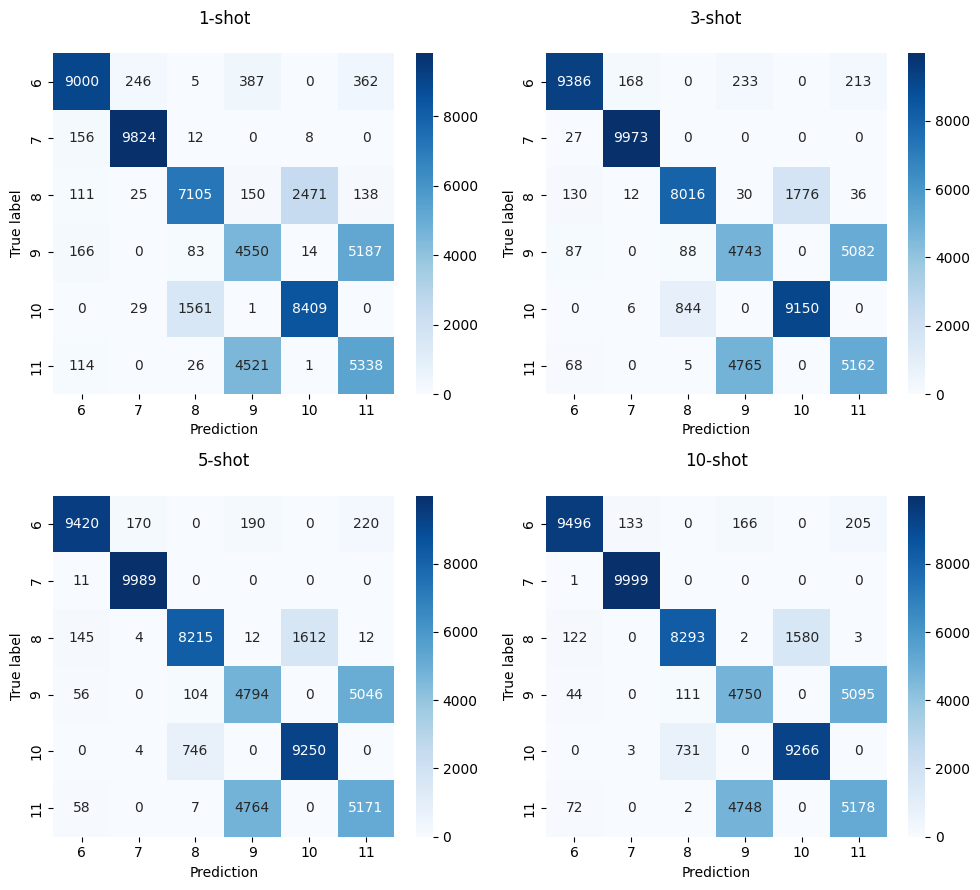

In [60]:
k_shots = [1, 3, 5, 10]

fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i, k_shot in enumerate(k_shots):
    cm = results[k_shot]["cm"]

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[6, 7, 8, 9, 10, 11],
        yticklabels=[6, 7, 8, 9, 10, 11],
        ax=axes[i]
    )

    axes[i].set_title(
        f"{k_shot}-shot\n"
    )
    axes[i].set_xlabel("Prediction")
    axes[i].set_ylabel("True label")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


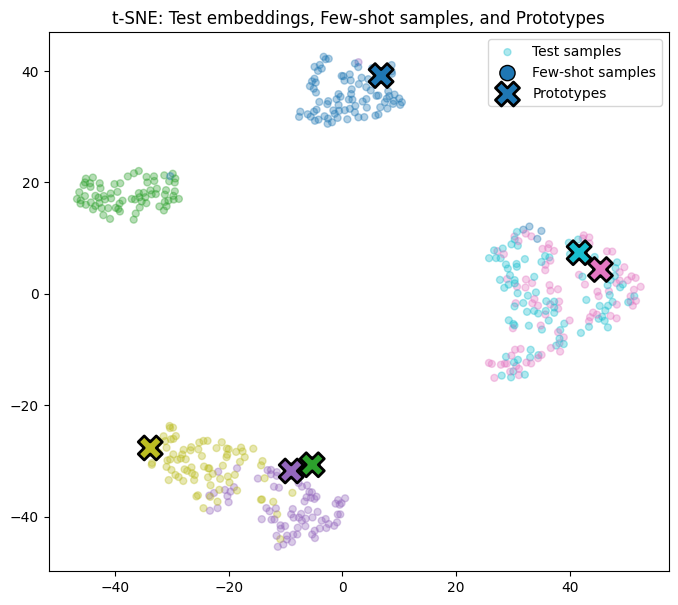

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

encoder.eval()

with torch.no_grad():
    Z_test = encoder(X_test.to(device)).cpu()
    Z_few  = encoder(X_few_shot.to(device)).cpu()
    Z_proto = prototypes.cpu()

Z_all = torch.cat([Z_test, Z_few, Z_proto], dim=0)

labels_all = torch.cat([
    y_test.cpu(),
    y_few_shot.cpu(),
    proto_labels.cpu()
])


point_type = torch.cat([
    torch.zeros(len(Z_test)),
    torch.ones(len(Z_few)),
    torch.ones(len(Z_proto)) * 2
])

tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=200,
    n_iter=2000,
    init="pca"
)

Z_2D = tsne.fit_transform(Z_all.numpy())


plt.figure(figsize=(8, 7))


mask_test = (point_type == 0)
plt.scatter(
    Z_2D[mask_test, 0], Z_2D[mask_test, 1],
    c=labels_all[mask_test], cmap="tab10",
    alpha=0.35, s=25,
    label="Test samples"
)


mask_few = (point_type == 1)
plt.scatter(
    Z_2D[mask_few, 0], Z_2D[mask_few, 1],
    c=labels_all[mask_few], cmap="tab10",
    edgecolors="black", linewidths=1,
    s=120, marker="o",
    label="Few-shot samples"
)


mask_proto = (point_type == 2)
plt.scatter(
    Z_2D[mask_proto, 0], Z_2D[mask_proto, 1],
    c=labels_all[mask_proto], cmap="tab10",
    marker="X", edgecolors="black",
    linewidths=2, s=300,
    label="Prototypes"
)

plt.title("t-SNE: Test embeddings, Few-shot samples, and Prototypes")
plt.legend()
plt.show()
